In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Toa_Payoh'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 3286


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129467,TOA PAYOH,2 ROOM,58,LOR 4 TOA PAYOH,44.0,Standard,1967,44 years 01 month,280000.0,11.0,65.0
129468,TOA PAYOH,2 ROOM,54,LOR 5 TOA PAYOH,43.0,Standard,1967,44 years 01 month,242000.0,2.0,65.0
129469,TOA PAYOH,3 ROOM,9,JOO SENG RD,68.0,Model A,2017,93 years 09 months,591000.0,11.0,65.0
129470,TOA PAYOH,3 ROOM,195,KIM KEAT AVE,66.0,Improved,1973,50 years 03 months,300000.0,8.0,65.0
129471,TOA PAYOH,3 ROOM,158,LOR 1 TOA PAYOH,65.0,Improved,1972,48 years 08 months,355000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153761,TOA PAYOH,5 ROOM,49,LOR 5 TOA PAYOH,126.0,Improved,1993,68 years 11 months,790000.0,8.0,76.0
153762,TOA PAYOH,5 ROOM,230,LOR 8 TOA PAYOH,117.0,Standard,1976,52 years 05 months,670000.0,20.0,76.0
153763,TOA PAYOH,5 ROOM,136,POTONG PASIR AVE 3,143.0,Model A-Maisonette,1984,60 years 03 months,993000.0,11.0,76.0
153764,TOA PAYOH,EXECUTIVE,237,LOR 1 TOA PAYOH,146.0,Maisonette,1986,62 years 03 months,900888.0,2.0,76.0


In [4]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 3286
0 of 227
10 of 227
20 of 227
30 of 227
40 of 227
50 of 227
60 of 227
check 7 UPP ALJUNIED LANE. No data returned
70 of 227
80 of 227
90 of 227
100 of 227
110 of 227
120 of 227
130 of 227
140 of 227
150 of 227
160 of 227
170 of 227
180 of 227
190 of 227
200 of 227
210 of 227
220 of 227
1 errors detected
pickle dumped. 3512


In [12]:
df_error = df[(df.street_name.str.startswith('UPP ALJUNIED'))&(df.block=='7')]
df_error

town                   11
flat_type              11
block                  11
street_name            11
floor_area_sqm         11
flat_model             11
lease_commence_date    11
remaining_lease        11
resale_price           11
floor                  11
date                   11
dtype: int64

In [14]:
dfL = df[(~df.street_name.str.startswith('UPP ALJUNIED'))|(df.block!='7')]
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
dfL.to_csv(file,index=False)
df = dfL.copy()
df


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
129467,TOA PAYOH,2 ROOM,58,LOR 4 TOA PAYOH,44.0,Standard,1967,44 years 01 month,280000.0,11.0,65.0
129468,TOA PAYOH,2 ROOM,54,LOR 5 TOA PAYOH,43.0,Standard,1967,44 years 01 month,242000.0,2.0,65.0
129469,TOA PAYOH,3 ROOM,9,JOO SENG RD,68.0,Model A,2017,93 years 09 months,591000.0,11.0,65.0
129470,TOA PAYOH,3 ROOM,195,KIM KEAT AVE,66.0,Improved,1973,50 years 03 months,300000.0,8.0,65.0
129471,TOA PAYOH,3 ROOM,158,LOR 1 TOA PAYOH,65.0,Improved,1972,48 years 08 months,355000.0,11.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
153761,TOA PAYOH,5 ROOM,49,LOR 5 TOA PAYOH,126.0,Improved,1993,68 years 11 months,790000.0,8.0,76.0
153762,TOA PAYOH,5 ROOM,230,LOR 8 TOA PAYOH,117.0,Standard,1976,52 years 05 months,670000.0,20.0,76.0
153763,TOA PAYOH,5 ROOM,136,POTONG PASIR AVE 3,143.0,Model A-Maisonette,1984,60 years 03 months,993000.0,11.0,76.0
153764,TOA PAYOH,EXECUTIVE,237,LOR 1 TOA PAYOH,146.0,Maisonette,1986,62 years 03 months,900888.0,2.0,76.0


In [15]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,798.000000,798.000000,7.980000e+02,798.000000,798.000000,798.000000,798.000000
mean,85.317043,1987.372180,5.872404e+05,11.458647,70.073935,103.851840,1.336024
std,23.700632,17.864767,2.691667e+05,9.268485,3.402456,0.009364,0.002734
min,38.000000,1967.000000,2.400000e+05,2.000000,65.000000,103.842595,1.330100
25%,67.000000,1972.000000,3.380000e+05,5.000000,67.000000,103.844337,1.334745
50%,76.500000,1984.000000,5.285000e+05,8.000000,70.000000,103.849165,1.334932
75%,102.000000,2002.000000,8.000000e+05,14.000000,73.000000,103.855915,1.337456
max,161.000000,2018.000000,1.385000e+06,41.000000,76.000000,103.881373,1.342783


SuggestedLRs(valley=0.001737800776027143, slide=6.309573450380412e-07)

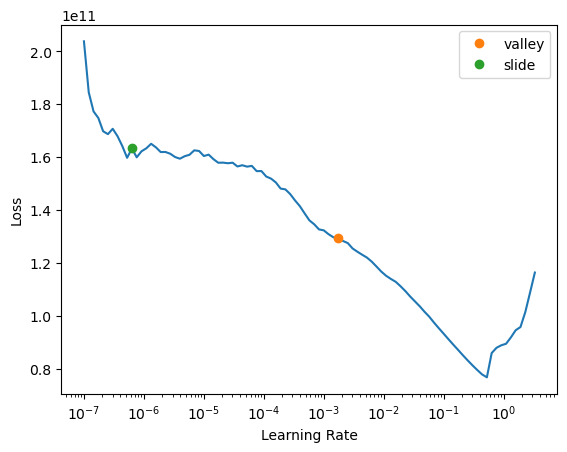

In [16]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [31]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 45104.515625.


(#2) [2060892672.0,45104.515625]

In [32]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 9*20
n2 = 3*20
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 60
10 of 60
20 of 60
30 of 60
40 of 60
50 of 60


In [33]:
import http.client, urllib.parse
import json

mrts = ["Toa Payoh MRT", "Braddell MRT", "Potong Pasir MRT", "Woodleigh MRT", "Bartley MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
    conn = http.client.HTTPConnection('api.positionstack.com')
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': mrt[:-4] + ' Station',
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
        print(f"check {add}. No data returned")
        count += 1
        errors.append(add)
        continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
        longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
        print(f"{first_response['label']}, confidence {first_response['confidence']}")
    else:
        print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 3773
Toa Payoh Station, Singapore, confidence 1
Braddell Station, Singapore, confidence 1
Potong Pasir Station, Singapore, confidence 1
Woodleigh Station, Singapore, confidence 1
Bartley Station, Singapore, confidence 1
pickle dumped. 3778


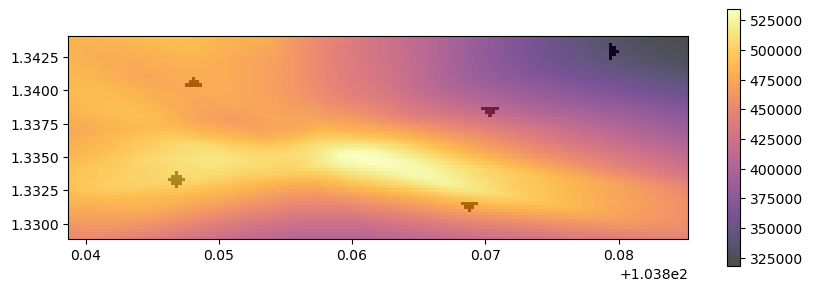

In [34]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_star(*min_coords(*longLats[mrts[0]]))
map_up(*min_coords(*longLats[mrts[1]]))
map_down(*min_coords(*longLats[mrts[2]]))
map_down(*min_coords(*longLats[mrts[3]]))
map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

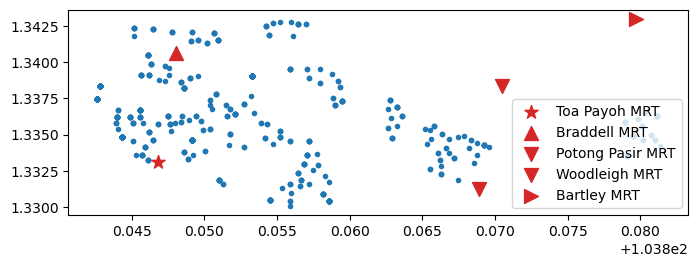

In [36]:
markers = ["*", '^', "v", 'v', '>', '^', '^']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower right')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
